In [1]:
import sionna.rt as rt
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.ndimage

plt.rc("savefig", format="jpeg")

In [2]:
N = 5
# N = 3
N_FREQ = 100
np.random.seed(0)

In [3]:
scene = rt.load_scene(rt.scene.etoile)

bboxes = [obj.mi_shape.bbox().min for obj in scene.objects.values()] + [
    obj.mi_shape.bbox().max for obj in scene.objects.values()
]
min_pos = np.min(bboxes, axis=0) * 0.4
max_pos = np.max(bboxes, axis=0) * 0.4
max_pos[2] = 2
for n in range(N):
    position = []
    for _min, _max in zip(min_pos, max_pos):
        position.append(np.random.uniform(_min, _max, 1))
    tx = rt.Transmitter(name=f"tx-{n}", position=position)
    scene.add(tx)
    rx = rt.Receiver(name=f"rx-{n}", position=position)
    scene.add(rx)

scene.tx_array = rt.PlanarArray(
    num_rows=1, num_cols=1, pattern="dipole", polarization="V"
)
scene.rx_array = rt.PlanarArray(
    num_rows=1, num_cols=1, pattern="dipole", polarization="V"
)
scene.frequency = 2.4e9

p_solver = rt.PathSolver()
paths = p_solver(
    scene=scene,
    max_num_paths_per_src=int(1e6),
    max_depth=20,
    diffuse_reflection=True,
)

fig = scene.preview(
    paths=paths,
)
fig.center_view()

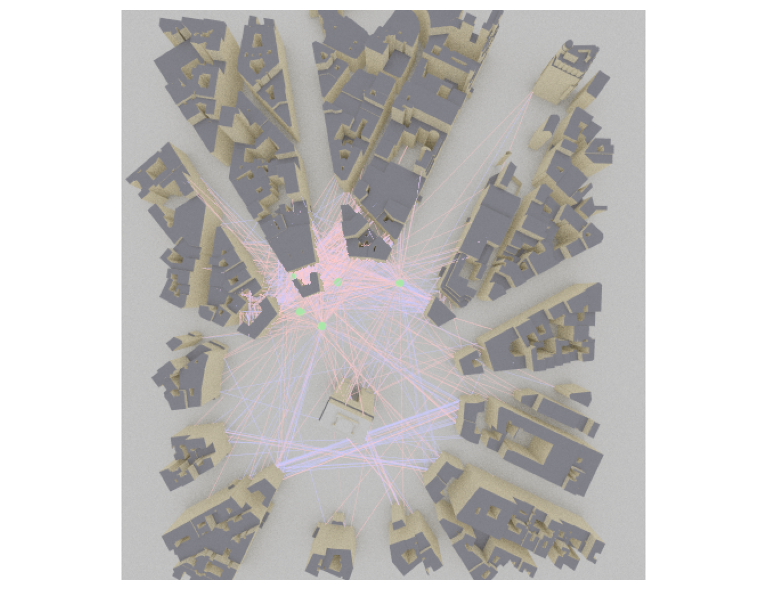

In [4]:
fig = scene.render(
    camera=rt.Camera(position=[0, 0, 200], look_at=[0, 0, 0]),
    paths=paths,  # rendering including paths takes so long time.
    fov=135,
)

正規化遅延時間では、最初のインパルス応答の時間を0とする。これは、`normalize_delays=True`で設定でき、デフォルトで`True`になっている。ここではそれをオフにして表示してみる。

[APIの説明](https://nvlabs.github.io/sionna/rt/api/paths.html#sionna.rt.Paths.cfr)にもあるとおり、cfrはcirをFFTしただけ。

In [5]:
frequencies = np.linspace(2.402e9, 2.480e9, N_FREQ)
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
h_freq = paths.cfr(
    frequencies=frequencies,
    out_type="numpy",
)

# Shape of a: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
# Shape of tau: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
a, tau = paths.cir(normalize_delays=False, out_type="numpy")
a_abs = np.abs(a)
a_max = np.max(a_abs)

/tmp/ipykernel_403772/3081305608.py:43: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout(w_pad=0)
/tmp/ipykernel_403772/3081305608.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


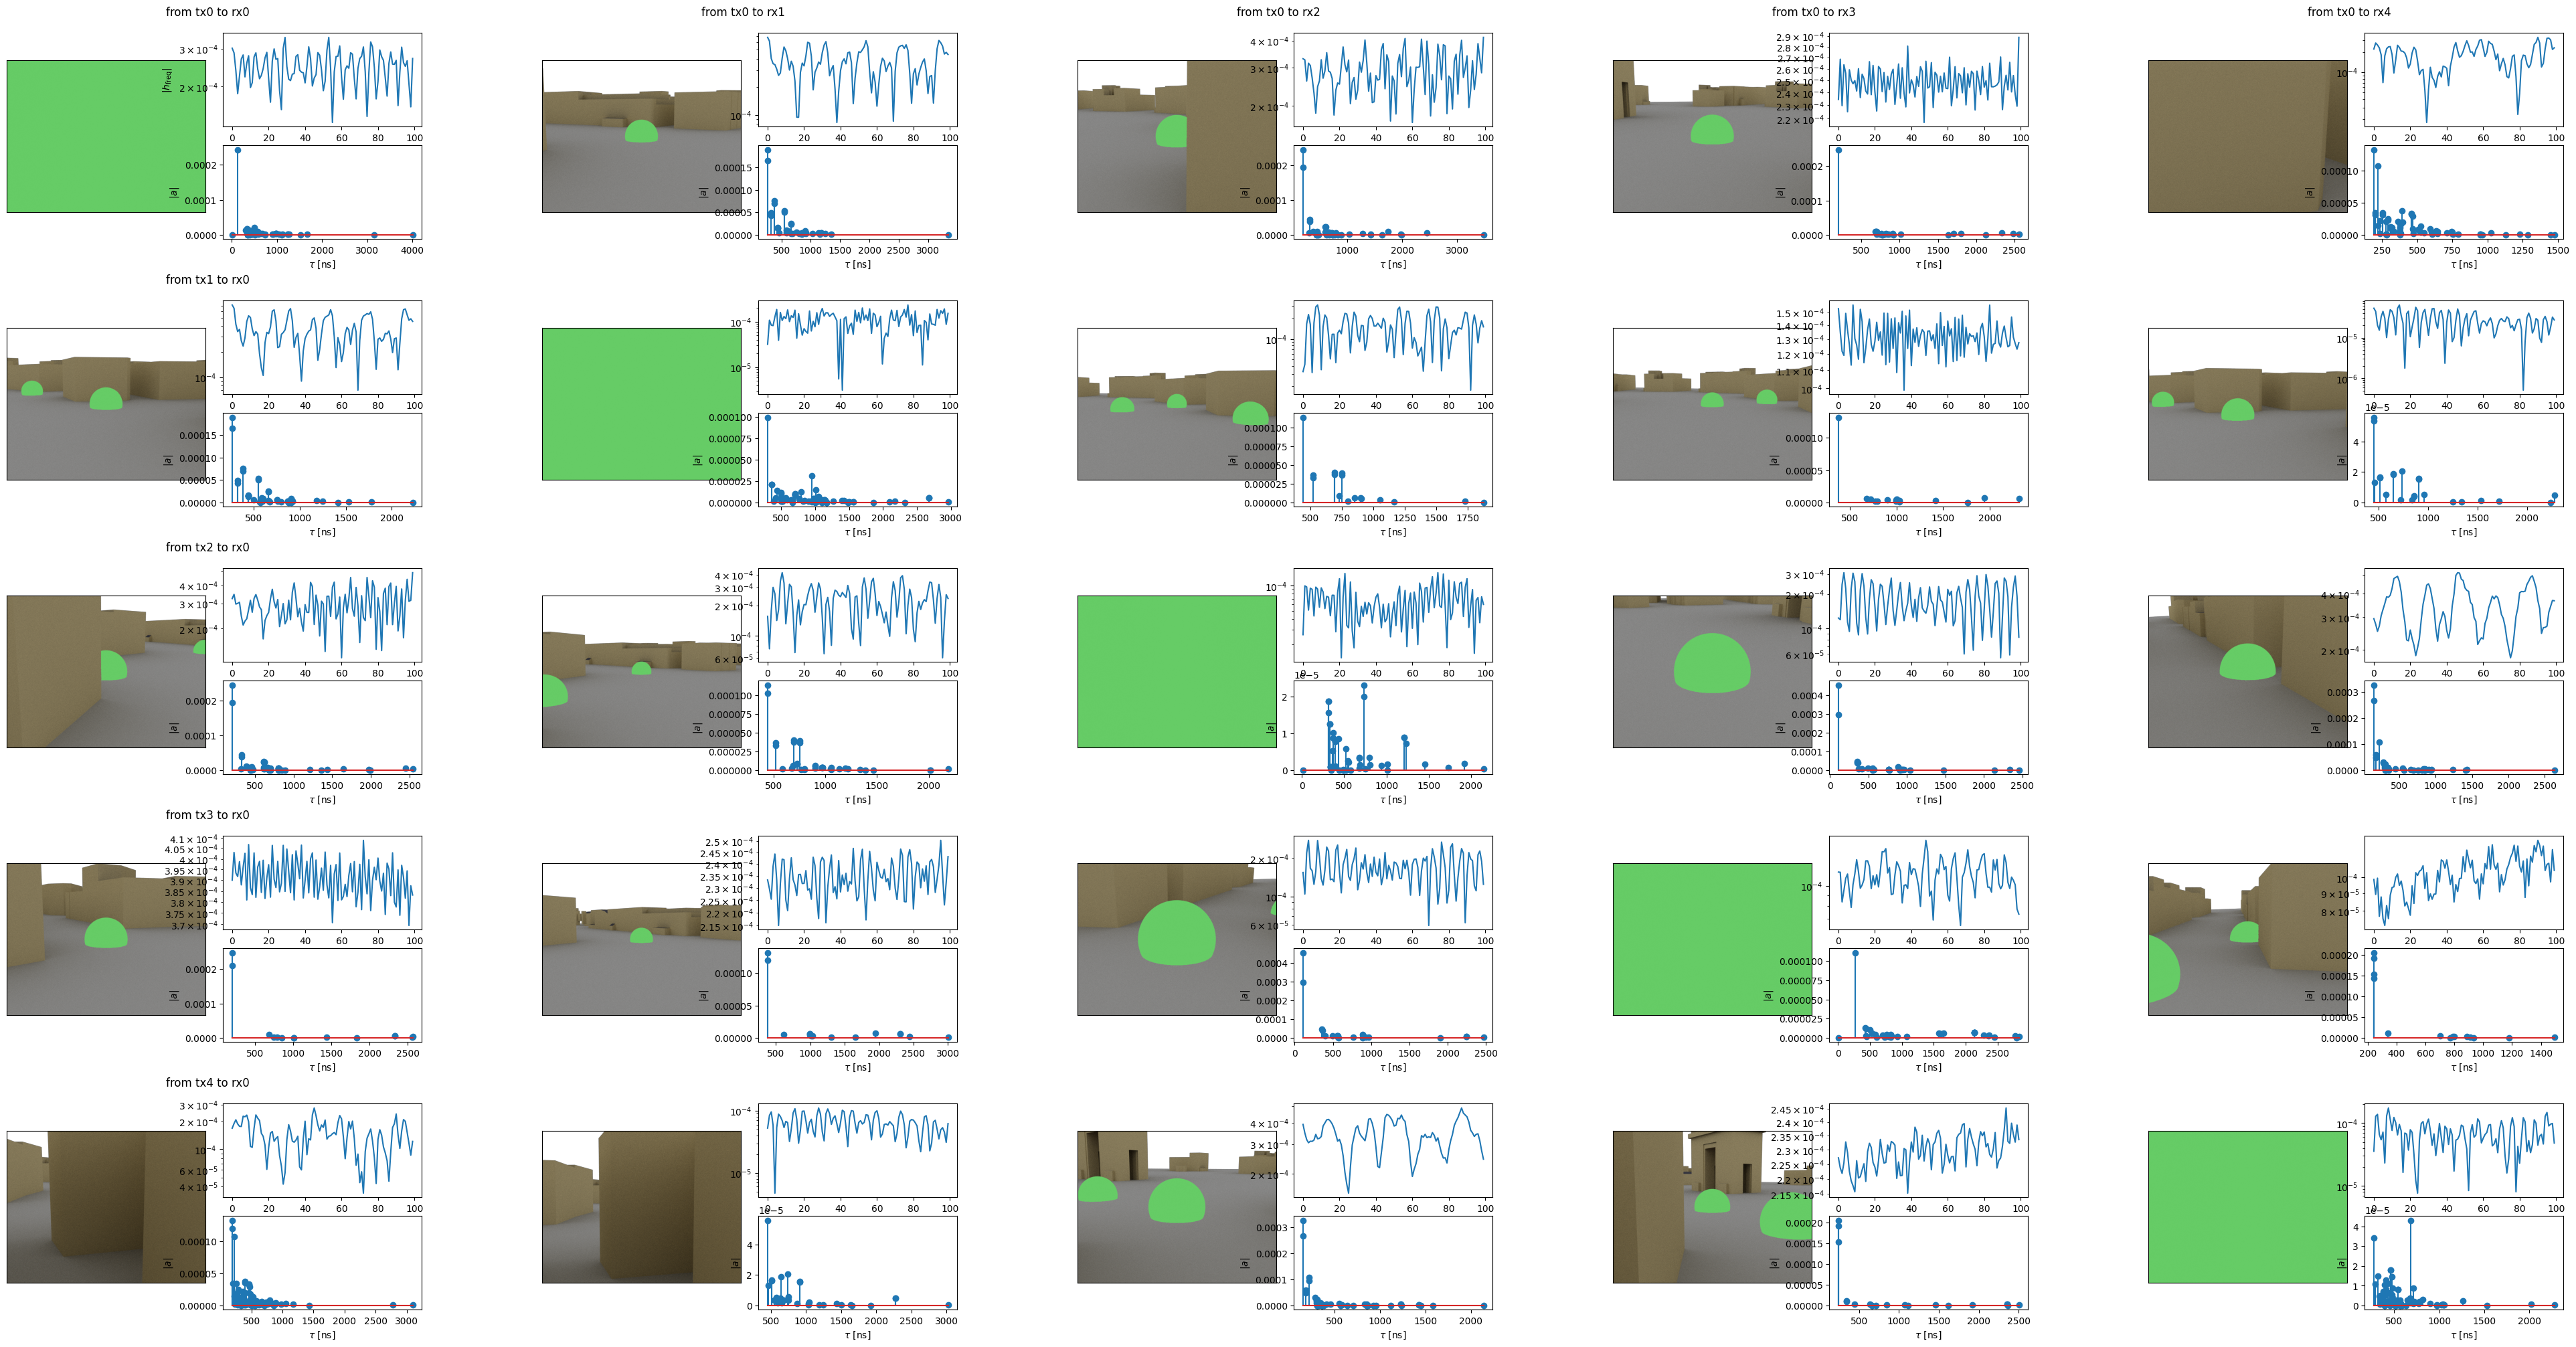

In [6]:
# fig = plt.figure(figsize=(60, 60))
fig = plt.figure(figsize=(N * 4 * 2, N * 4))
subfigures = fig.subfigures(N, N)
for x in range(N):
    for y in range(N):
        subfig = subfigures[y][x]
        gs = subfig.add_gridspec(2, 4)
        if y == 0:
            subfig.suptitle(f"from tx{y} to rx{x}")
        if x == 0:
            subfig.suptitle(f"from tx{y} to rx{x}")

        ax = subfig.add_subplot(gs[0:2, 0:2])
        bitmap = scene.render(
            camera=rt.Camera(
                position=scene.get(f"tx-{y}").position + [0, 0, 10],
                look_at=scene.get(f"rx-{x}").position,
            ),
            return_bitmap=True,
        )
        ax.imshow(bitmap)
        ax.set_xticks([])
        ax.set_yticks([])

        ax = subfig.add_subplot(gs[0, 2:])
        ax.plot(np.abs(h_freq)[x, 0, y, 0, 0, :])
        ax.set_yscale("log")
        if x == 0 and y == 0:
            ax.set_xlabel("Subcarrier index")
            ax.set_ylabel(r"|$h_\text{freq}$|")

        ax = subfig.add_subplot(gs[1, 2:])
        t = tau[x, y, :] / 1e-9
        mask = t > 0
        if mask.sum() != 0:
            ax.stem(t[mask], a_abs[x, 0, y, 0, :, 0][mask])
            ax.set_xlabel(r"$\tau$ [ns]")
            ax.set_ylabel(r"$|a|$")
        if x == 0 and y == 0:
            ax.set_xlabel(r"$\tau$ [ns]")
            ax.set_ylabel(r"$|a|$")

fig.tight_layout(w_pad=0)
fig.show()

## インパルス応答

- 遅延プロファイル: $p(\tau)=<h^*(t)h(t)>$
- 平均遅延: 遅延プロファイルの時間に対する電力での重み付き平均
- 遅延スプレッド: 同様に標準偏差を求めたもの

In [7]:
x = 3
y = 0
a.shape

(5, 1, 5, 1, 78, 1)

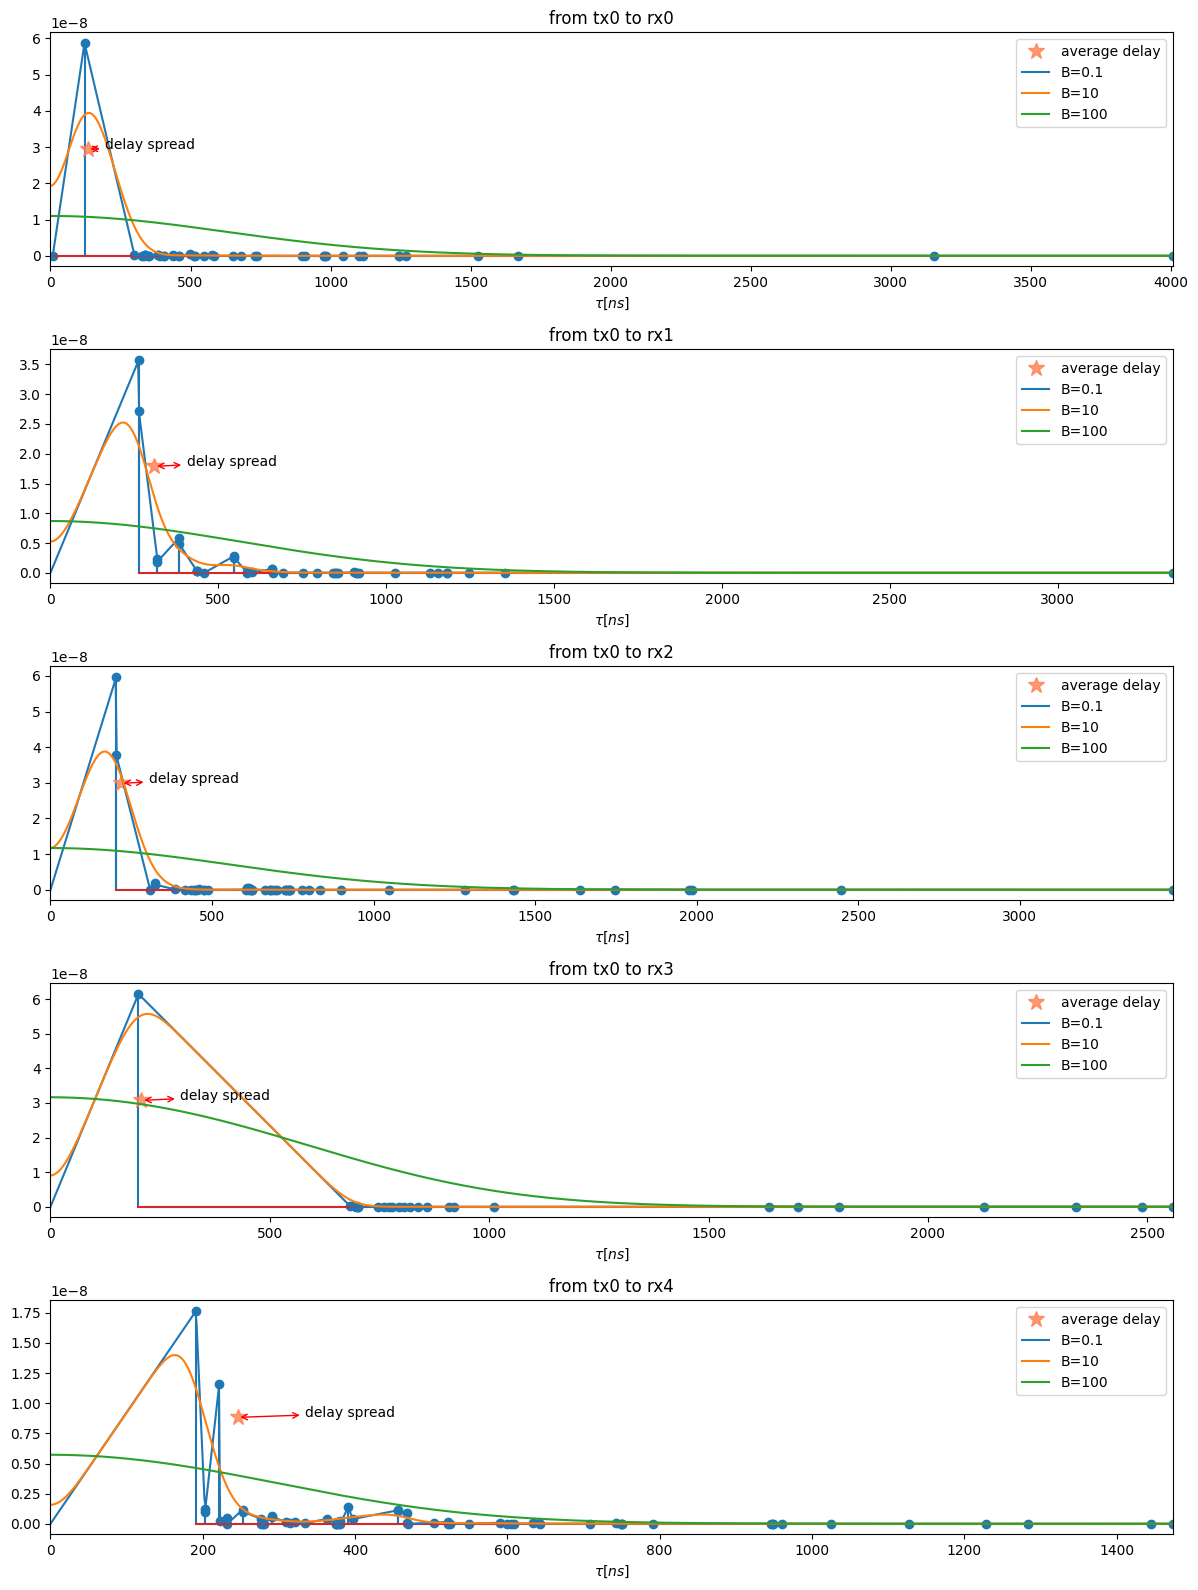

In [8]:
fig, axes = plt.subplots(N, 1, figsize=(12, 16))
axes = axes.flatten()
for x in range(N):
    ax = axes[x]
    h = a[x, 0, 0, 0, paths.valid[x, 0, :], 0]
    t = tau[x, 0, paths.valid[x, 0, :]] / 1e-9
    p = np.square(np.abs(h))
    ax.stem(t, p)
    average = np.average(t, weights=p)
    # ax.arrow(0, np.mean(p), mean, 0, width=np.max(p) / 100, head_width=np.max(p) / 50)
    ax.plot(
        average,
        np.max(p) / 2,
        "*",
        markersize=12,
        color="coral",
        alpha=0.8,
        label="average delay",
    )
    spread = np.sqrt(np.average((t - average) ** 2, weights=p))
    ax.annotate(
        "delay spread",
        (average, np.max(p) / 2),
        (average + spread, np.max(p) / 2),
        arrowprops=dict(arrowstyle="<->", color="red"),
    )

    t = np.insert(t, 0, 0)
    p = np.insert(p, 0, 0)
    t_interp = np.linspace(t.min(), t.max(), 1000)
    p_interp = scipy.interpolate.interp1d(t, p, fill_value=0)(t_interp)
    for B in [0.1, 10, 100]:
        A = np.sqrt(np.pi / 2 / np.log(2)) * B
        ax.plot(t_interp, scipy.ndimage.gaussian_filter1d(p_interp, A), label=f"B={B}")
    # ax.plot(t_interp, p_interp)

    ax.set_xlim((0, np.max(t)))
    ax.set_xlabel(r"$\tau [ns]$")
    ax.set_ylabel("")
    ax.set_title(f"from tx0 to rx{x}")
    ax.legend()
fig.tight_layout()